## 用全连接神经网络在MNIST数据集上进行手写数字识别
数据集：https://www.kaggle.com/c/digit-recognizer/data
训练集42000张，
测试集 28000张，
每幅图像：28*28 黑白图，每个像素值为0到和255之间数值

## 导入工具包

In [1]:
import numpy as np 
import pandas as pd # 数据处理
import matplotlib.pyplot as plt # 画图
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Import Torch 
import torch
import torch.nn as nn

from torch import nn, optim

## 读入数据

In [2]:
train = pd.read_csv("./data/MNIST_train.csv")
test = pd.read_csv("./data/MNIST_test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 数据预处理

In [3]:
y = train.label.values
X = train.drop("label",axis=1).values

#2D图像，像素值[0,255]  --> [0,1]  --> [-1, 1](神经网络的输入在-1到1之间更容易收敛)
X = X/255.0
X = (X)*2 - 1
#X = X.reshape(-1, 1, 28, 28)  #(samples, channels, height, width))

In [4]:
#验证集：20%
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)

### 转换成Tensor

In [5]:
#train set
X_train_tensor = torch.from_numpy(X_train).type(torch.float)
y_train_tensor = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

#test set
X_test_tensor = torch.from_numpy(X_test).type(torch.float)
y_test_tensor = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

### 装载数据

In [6]:
# Set batch size
batch_size = 32

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train_tensor,y_train_tensor)
test = torch.utils.data.TensorDataset(X_test_tensor,y_test_tensor)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

## 定义网络结构


In [7]:
class fc_net(torch.nn.Module):
    def __init__(self):
        super(fc_net,self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(784,512),nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(512,256),nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(256,128),nn.ReLU())
        self.fc4 = nn.Sequential(nn.Linear(128,64),nn.ReLU())
        self.fc5 = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

## 模型训练

In [8]:
#生成模型实例
model = fc_net()

#损失函数
criterion  = nn.CrossEntropyLoss(size_average=False)

# 学习率超参
#learning_rate = 0.0015
learning_rate = 0.001
# 优化器
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

epochs = 50
train_losses, test_losses = [], []
n_train_samples = len(X_train_tensor)
n_test_samples=len(X_test_tensor)
for epoch in range(epochs):
    running_loss, running_acc = 0., 0.
    for (img, label) in train_loader:
        
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predict = torch.max(output, 1)
        correct_num = (predict == label).sum()
        running_acc += correct_num.item()
        
    running_loss /= n_train_samples
    running_acc /= n_train_samples
    
    #验证误差
    # Turn off gradients for validation
    with torch.no_grad():
        test_loss, test_acc = 0., 0.
        for images, labels in test_loader:
            output = model(images)
            loss = criterion(output, labels)

            test_loss += loss.item()
            _, predict = torch.max(output, 1)
            correct_num = (predict == labels).sum()
            test_acc += correct_num.item()
    
    test_loss /=n_test_samples
    test_acc /=n_test_samples
    
    train_losses.append(running_loss)
    test_losses.append(test_loss)
                
    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Training Accuracy: {:.3f} %".format(100*running_acc),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f} %".format(100*test_acc))
    
# 保存模型
torch.save(model, 'fc.pth.tar')

/Users/qing/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


('Epoch: 1/50.. ', 'Training Loss: 1.086.. ', 'Training Accuracy: 62.414 %', 'Test Loss: 0.430.. ', 'Test Accuracy: 85.190 %')
('Epoch: 2/50.. ', 'Training Loss: 0.295.. ', 'Training Accuracy: 90.890 %', 'Test Loss: 0.212.. ', 'Test Accuracy: 93.417 %')
('Epoch: 3/50.. ', 'Training Loss: 0.192.. ', 'Training Accuracy: 94.152 %', 'Test Loss: 0.168.. ', 'Test Accuracy: 94.738 %')
('Epoch: 4/50.. ', 'Training Loss: 0.142.. ', 'Training Accuracy: 95.631 %', 'Test Loss: 0.136.. ', 'Test Accuracy: 95.750 %')
('Epoch: 5/50.. ', 'Training Loss: 0.115.. ', 'Training Accuracy: 96.443 %', 'Test Loss: 0.119.. ', 'Test Accuracy: 96.214 %')
('Epoch: 6/50.. ', 'Training Loss: 0.095.. ', 'Training Accuracy: 96.949 %', 'Test Loss: 0.193.. ', 'Test Accuracy: 93.310 %')
('Epoch: 7/50.. ', 'Training Loss: 0.080.. ', 'Training Accuracy: 97.458 %', 'Test Loss: 0.118.. ', 'Test Accuracy: 96.524 %')
('Epoch: 8/50.. ', 'Training Loss: 0.069.. ', 'Training Accuracy: 97.810 %', 'Test Loss: 0.100.. ', 'Test Accur

/Users/qing/anaconda2/lib/python2.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type fc_net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [9]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 98 %


## 显示训练误差和验证误差

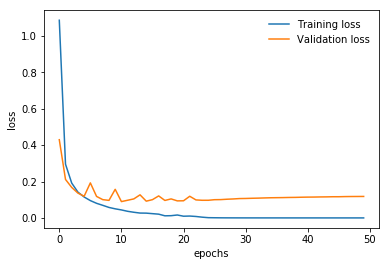

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')

plt.xlabel("epochs")
plt.ylabel("loss")

plt.legend(frameon=False)